In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from idlmam_custom import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

<Axes: >

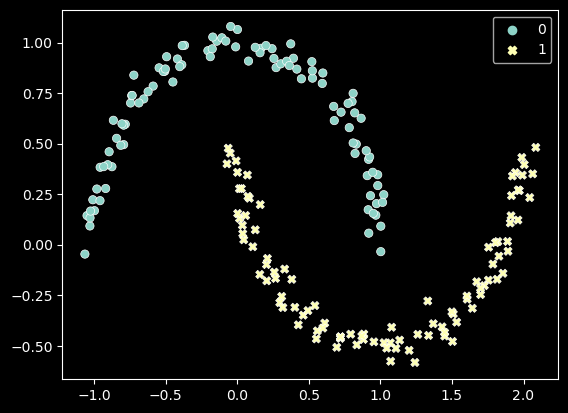

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

We need to be consistent with the chosen device.

In [3]:
from sklearn.metrics import accuracy_score, f1_score
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
testing_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = nn.CrossEntropyLoss()

In [4]:
results_pd = train_network(model, f_loss, training_loader, test_loader=testing_loader, optimizer = optimizer, 
                           epochs=5, device=device, score_funcs={'Acc': accuracy_score, 'F1': f1_score},
                           checkpoint_file='model.pt', disable_tqdm=False )
results_pd

Epoch: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.335338,0.348310,0.316897,0.838250,0.875,0.841887,0.873096
1,1,0.634200,0.279036,0.275551,0.876125,0.880,0.876695,0.878788
2,2,0.868494,0.255882,0.230814,0.885500,0.890,0.885729,0.888889
3,3,1.106894,0.202034,0.171813,0.915250,0.925,0.915440,0.926829
4,4,1.333684,0.138056,0.112129,0.949000,0.955,0.949051,0.955224


<Axes: xlabel='total time', ylabel='train Acc'>

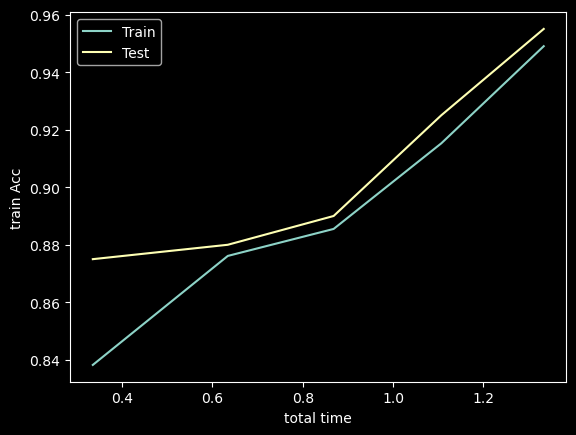

In [5]:
sns.lineplot(x='total time', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='Test')

In [6]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

#if we want to continue training with a new instance of the model, we need a new
#optimizer targeting the parameters of that new model instance. also, ESSENTIAL:
# https://stackoverflow.com/questions/66091226/runtimeerror-expected-all-tensors-to-be-on-the-same-device-but-found-at-least
# https://discuss.pytorch.org/t/code-that-loads-sgd-fails-to-load-adam-state-to-gpu/61783/5?u=shaibagon
optimizer_new = torch.optim.AdamW(model_new.parameters())

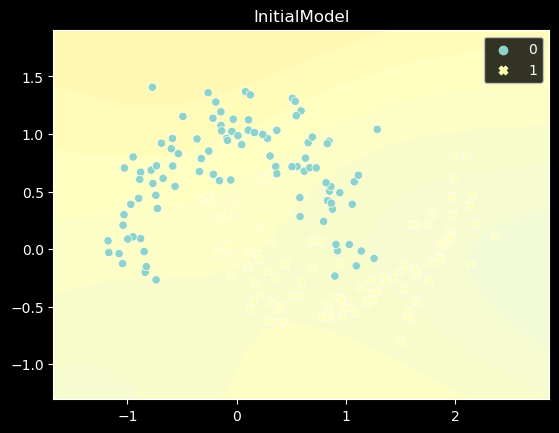

In [7]:
visualize2DSoftmax(X_test, y_test, model_new, title="InitialModel")

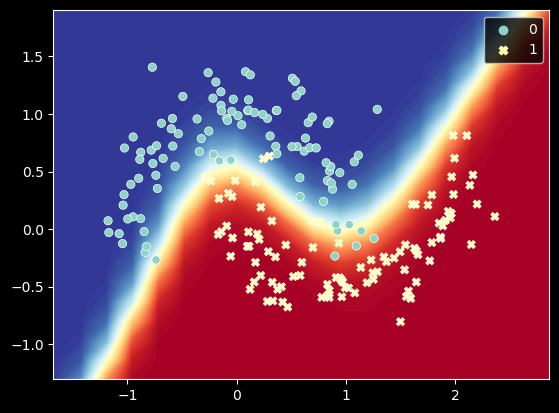

In [8]:
checkpoint_dict = torch.load('model.pt', map_location=device)

model_new.load_state_dict(checkpoint_dict['model_state_dict'])
optimizer_new.load_state_dict(checkpoint_dict['optimizer_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new)

In [9]:
results_pd = train_network(model_new, f_loss, training_loader, test_loader=testing_loader, optimizer = optimizer_new, 
                           epochs=10, device=device, score_funcs={'Acc': accuracy_score, 'F1': f1_score},
                           checkpoint_file='model_new.pt' )
results_pd

Epoch: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.242754,0.104196,0.091829,0.962750,0.955,0.962806,0.955224
1,1,0.490571,0.093365,0.091164,0.966375,0.955,0.966430,0.954774
2,2,0.726881,0.086852,0.101185,0.966875,0.955,0.966887,0.955224
3,3,0.986778,0.084056,0.079492,0.969250,0.955,0.969296,0.955224
4,4,1.232063,0.083976,0.082428,0.967750,0.955,0.967734,0.955224
5,5,1.472890,0.080772,0.102970,0.969500,0.950,0.969523,0.949495
6,6,1.720380,0.080958,0.080259,0.968375,0.955,0.968363,0.954774
7,7,2.070807,0.079399,0.093283,0.969375,0.955,0.969417,0.955665
8,8,2.298049,0.081046,0.079965,0.969125,0.950,0.969121,0.949495
9,9,2.533283,0.081272,0.079408,0.968875,0.945,0.968902,0.944724


<Axes: xlabel='total time', ylabel='train Acc'>

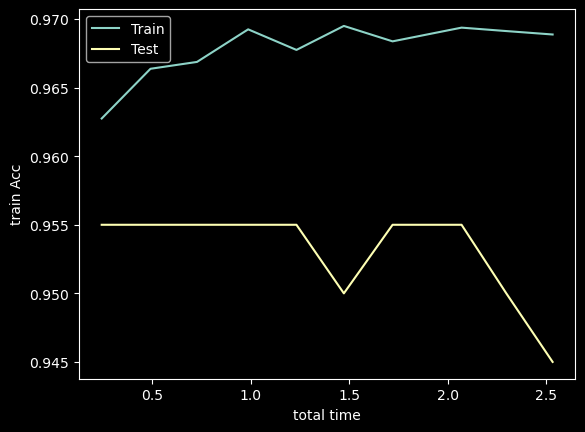

In [10]:
sns.lineplot(x='total time', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='Test')